# Project: Investigation of Medical Appointment Statistics in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This report investigates a dataset of 100k medical appointments in Brazil: [no-show-appointment][1]. The dataset is focused on the question of whether patients show up to their appointments according to different factors. Some of the factors to take into account:

- 'ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program [Bolsa Família][2].
- several symptoms like: 'Hypertension', 'Diabetes', 'alcoholism' and 'handicap'
- 'Sms-received': whether the patient received an sms of the appointment or not.

The report aims firstly to investigate the Brazilian health care system and to find a number of factors that can lead to the patient not showing for an appointment. For that, the questions to be answered are as follows:

> - What factors are important for knowing if a patient will show up to an appointment or not?
> - How is the problem (not showing for appointments) distributed accross the locations in Brazil?
> - How is the problem distributed across age and gender of patients? 




[1]: https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv&sa=D&ust=1579452823958000

[2]: https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

In [1]:
# importing packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling
In this section, we will take a better look at the data and try to clean it so it can be used properly in the next section.

### General Properties

In the first step, we will just see general information about the data.

In [2]:
# Loading data for inspection
df = pd.read_csv("appointment_2016.csv")
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [3]:
df.shape

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


We can see from the above data that the dataset consists of 13 columns and 110527 rows. None of the columns have missing values and they all have proper types. However, column names can be written in a better fomat to make it easier to process the data.

In [5]:
# lets correct the column names here:
df = df.rename(columns=lambda x: x.lower().replace("id", "_id").replace("day", "_day").replace("-", "_"))
# also fix typos
df = df.rename(columns={'handcap': 'handicap', 'hipertension': 'hypertension'})
df.head(1)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


### Looking for Errors and Inconsistencies
now that we have proper column names, we need to  start looking for other problems like duplicate rows, errors in values and Other typos.

In [6]:
# my first instinct was to look for duplicated appointments:
df.appointment_id.duplicated().sum()

0

In [7]:
# no duplicates in appointment id, but we can view duplicates in other ways:
# if the same patient (patient_id) scheduled on the same day (scheduleday) and for the same appointment (appointmentday)
# Then we consider it as a duplicate to be removed.

df.duplicated(subset=['patient_id', 'scheduled_day', 'appointment_day']).sum()

1334

Since there are duplicate values, we now need to remove them:

In [8]:
# we now drop duplicate rows:
df = df.drop_duplicates(subset=['patient_id', 'scheduled_day', 'appointment_day'])
# check to see if the number of rows was reduced by 1334:
df.shape

(109193, 14)

Now, lets look at problems in the variables themselves. We will split the analysis according to the type of variables.

#### Numeric Variables

In [9]:
# check the data for errors in range:

df.describe()

,patient_id,appointment_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,1.091930e+05,1.091930e+05,109193.000000,109193.000000,109193.000000,109193.000000,109193.000000,109193.000000,109193.000000
mean,1.475156e+14,5.675754e+06,37.097003,0.098230,0.197375,0.071864,0.030496,0.022199,0.322869
std,2.560832e+14,7.116187e+04,23.140858,0.297626,0.398020,0.258263,0.171950,0.161109,0.467575
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.176590e+12,5.640751e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.172600e+13,5.680911e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439580e+13,5.725954e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


From the above table, we can see several problems:
- `age` variable should not be negative (min is set to -1)
- `handicap` variable should not have values other than 0 and 1 (max is 4)

In [10]:
# check the age variable:
df.query('age <0')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,4.659430e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [11]:
# now dropping the incorrect row:
df = df.drop(df.query('age < 0').index)
df.query('age<0').shape

(0, 14)

In [12]:
# now we check the handicap value, it should be either 0 or 1
df.query('handicap not in [0,1]').head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
946,7.282580e+13,5582483,M,2016-04-14T09:26:08Z,2016-04-29T00:00:00Z,94,BELA VISTA,0,1,1,0,2,1,No
1665,1.242920e+13,5525497,M,2016-03-30T09:16:41Z,2016-04-29T00:00:00Z,64,SANTA MARTHA,0,1,0,1,2,1,No
2071,1.242920e+13,5640120,M,2016-04-29T10:08:48Z,2016-04-29T00:00:00Z,64,SANTA MARTHA,0,1,0,1,2,0,No
2091,1.491830e+13,5638626,F,2016-04-29T08:13:59Z,2016-04-29T00:00:00Z,11,ANDORINHAS,0,0,0,0,2,0,No
2213,3.423831e+09,5640766,F,2016-04-29T11:22:50Z,2016-04-29T00:00:00Z,29,VILA RUBIM,0,0,0,0,2,0,No


In [13]:
# lets remove any value that is not 0 or 1
df = df.query('handicap in [0,1]')
df.shape

(108997, 14)

#### Checking time values
In this step, we need to do 2 things:
- Convert `scheduled_day` and `appointment_day` to datetime and remove date [check here][1]
- Check for incorrect dates

[1]:https://stackoverflow.com/questions/29310116/removing-time-from-datetime-variable-in-pandas

In [14]:
# first convert to date time 
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']).dt.date
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.date
df.head(2)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [15]:
# now check to see if appointment day is always after scheduled day
df.query('scheduled_day > appointment_day').shape

(5, 14)

In [16]:
# as you can see above, we need to remove 5 instances:
df = df.drop(df.query('scheduled_day > appointment_day').index)
df.query('scheduled_day > appointment_day').shape # check again

(0, 14)

In [17]:
# lets check if there is any problem with the dates:
df.query('scheduled_day == scheduled_day.min() or scheduled_day == scheduled_day.max()').head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
3764,8.322560e+14,5030230,F,2015-11-10,2016-05-04,51,RESISTÊNCIA,0,0,0,0,0,1,No
84176,3.558840e+13,5786409,F,2016-06-08,2016-06-08,71,REPÚBLICA,0,1,0,0,0,0,No
84178,3.187569e+10,5787083,F,2016-06-08,2016-06-08,54,REPÚBLICA,0,1,0,0,0,0,No


In [18]:
# no problem above, lets check the next one:
df.query('scheduled_day == scheduled_day.min() or scheduled_day == scheduled_day.max()').head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
3764,8.322560e+14,5030230,F,2015-11-10,2016-05-04,51,RESISTÊNCIA,0,0,0,0,0,1,No
84176,3.558840e+13,5786409,F,2016-06-08,2016-06-08,71,REPÚBLICA,0,1,0,0,0,0,No
84178,3.187569e+10,5787083,F,2016-06-08,2016-06-08,54,REPÚBLICA,0,1,0,0,0,0,No


The above tables show that the dates are now formatted properly. We can see that the databases starts from 10/11/2015 to 08/06/2016.
#### Categorical Variables
Since the `describe` function shows only numerical variables, we need to check categorical variables alone. Luckily, we have only two variables to check: `gender` and `no_show`.

In [19]:
# checking the gender variable, this should only contain male and female values:
df.gender.value_counts()

F    70858
M    38134
Name: gender, dtype: int64

In [20]:
# similarly, we check the no_show values, it should only be yes or no:
df.no_show.value_counts()

No     87177
Yes    21815
Name: no_show, dtype: int64

Even though no action is needed for both variables. I find the variable `no_show` to be confusing; it would be better to have a variable where 'Yes' means something positive.

In [21]:
# change no_show to show
df['show'] = df['no_show'].replace(to_replace=['Yes', 'No'],value= ['No', 'Yes'] )
# after making sure it works, we remove the no_show variable
del df['no_show']
df.head(1)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,show
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,Yes


<a id='eda'></a>
## Exploratory Data Analysis

After Trimming and cleaning the data, it is time for exploring our posed questions. 
### 1 - Factors Affecting Showing Up for Appointments
. We have 6 factors that possibly affect the `show` variable:
- `scholarship`: whether someone is enrolled in Brasilian welfare program.
- `hipertension`
- `diabetes`
- `alcoholism`
- `handicap`
- `sms_received`: whether the patient was sent a reminder or not. 

Lets explore these variables together.

In [22]:
# lets check these variables again
df.iloc[:,7:].head()

,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,show
0,0,1,0,0,0,0,Yes
1,0,0,0,0,0,0,Yes
2,0,0,0,0,0,0,Yes
3,0,0,0,0,0,0,Yes
4,0,1,1,0,0,0,Yes


In [23]:
# group by no_show to check trends
df_show = df.iloc[:,7:].groupby('show').sum()
df_show

,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
show,,,,,,
No,2530,3669,1402,660,354,9708
Yes,8178,17799,6402,2665,1661,25500


The results from the table show that all these variables have an effect on showing up for appointment. But, lets see the same results with some visuals and using proportions instead of count.

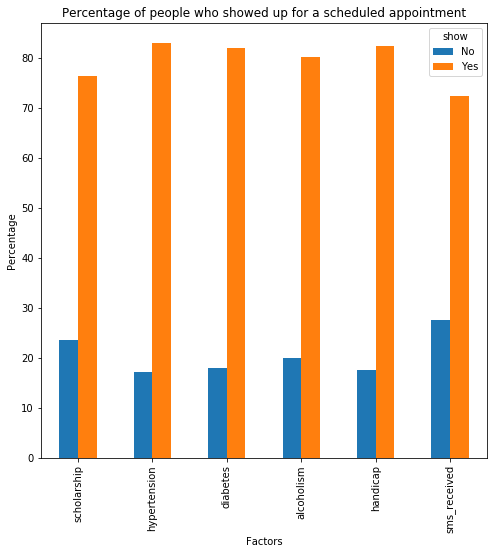

In [24]:
# in order to plot the variables we need to transpose the table
df_T = df_show.T
total = df_T['No']+  df_T['Yes']
df_T['No'] /= total /100
df_T['Yes'] /= total /100
df_T.plot(kind='bar', figsize=[8,8])
plt.title('Percentage of people who showed up for a scheduled appointment')
plt.xlabel('Factors')
plt.ylabel('Percentage');

The above bar chart shows that all factors are related to patients showing up.

However, we still have a problem: we need to know if the factors themselves had the impact of increasing the likelihood of the patient to show up. For this, for each variable we need to compare the results when the variable is present (1) and when it is not.

In [25]:
def get_difference(colnum, colname):
    '''
    This function will get each of the factors (scholarship , handicap ,etc)
    it will return two numbers:
    the percentage of people who showed up for appointment when the factor is 0
    the percentage of people who showed up for appointment when the factor is 1
    '''
    # first we make a copy
    df2 = df.copy()
    # temporary variable to count the zeros
    df2['temp'] = 1
    # this will total all the zeros and all the 1s
    total = df2.iloc[:,[colnum,13]].groupby(colname).count()['show'].to_list()
    # this will group the data by two columns: the factor itself and the 'show' factor
    df3 = df2.iloc[:,[colnum,13,14]].groupby([colname, 'show']).count()
    temp =  list(df3['temp'])
    # now we divide each number by the total
    percentage =  [temp[i]/total[0] if i < 2 else temp[i]/total[1] for i in range(len(temp))]
    return (percentage[1], percentage[3])



In [26]:
# using the above function we create a table
# containing the percentage when the factor is present and when it is not 
# for example 0.8 in the scholarship column means the percentage of people who
# showed up for appointment in the group of people who did not have a scholarship.
cols = df.columns[7:-1].to_list()
factor = ('No', 'Yes')
new_dict = {}
for i in range(len(cols)):
    new_dict[cols[i]] = get_difference(i+7, cols[i])
data = pd.DataFrame(new_dict, index=factor)
data

,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
No,0.803783,0.792674,0.798267,0.799796,0.799387,0.835913
Yes,0.763728,0.829094,0.820349,0.801504,0.824318,0.724267


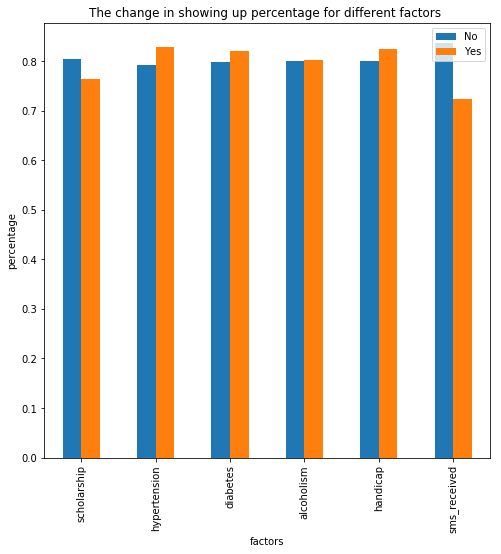

In [27]:
data.T.plot(kind='bar', figsize=[8,8]);
plt.title('The change in showing up percentage for different factors ')
plt.xlabel('factors')
plt.ylabel('percentage');

From the results above, we can see several results:

- Being enrolled in a welfare program or receiving a reminding message seems to reduce the percentage of people showing up to appointments.
- People with chronic illnesses are more likely to show for appointments than people without ones.
- alcoholism seems to have no effect on whether the patient shows up for the appointment or not.

It is also worth noting that even though `scholarship` and `sms_received` variables seem to have a negative effect on whether a patient shows up for an appoitment, it may be influenced by other factors. However, a deeper analysis is needed.

### 2- Distribution according to location

Now, it is time to see if there are any trends relevant to location.

In [28]:
df.neighbourhood.nunique()

81

There are 81 unique locations to be shown. lets see the distributions:

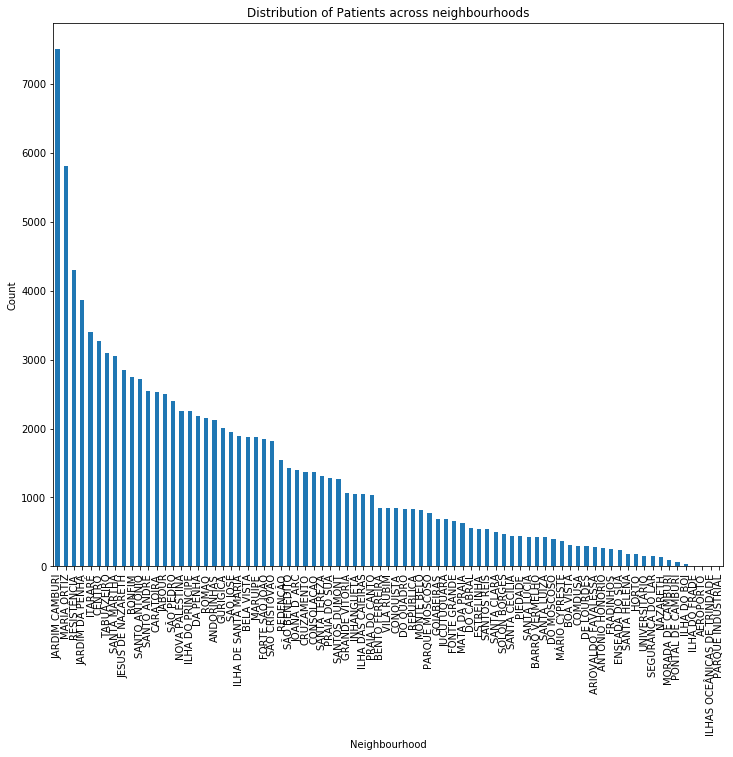

In [29]:
df.neighbourhood.value_counts().plot(kind='bar',figsize=[12,10]);
plt.title('Distribution of Patients across neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Count');

The above graph shows the counts in the database for each city. We can see that most of the cases are done in one location:
'Jardim Camburi'.

In [30]:
df2= df.copy()
df2[ 'temp'] = 1 # for counting purposes

df3 = df2.iloc[:,[6,13,14]].groupby(['neighbourhood','show']).count()
# get percentage instead of count, idea found here: https://stackoverflow.com/questions/23377108
perc = df3.groupby(level=0).apply(lambda x: 100.0*x /x.sum())
perc.head()

temp
neighbourhood   show           
AEROPORTO       No    12.500000
                Yes   87.500000
ANDORINHAS      No    22.149226
                Yes   77.850774
ANTÔNIO HONÓRIO No    18.450185

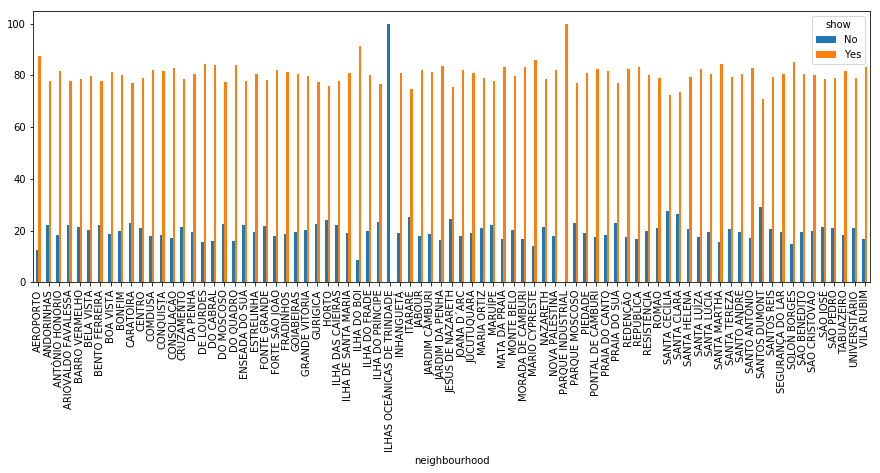

In [31]:
# the 'unstack' function was needed to plot the data properly
# function found here: https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html
perc['temp'].unstack().plot(kind='bar',figsize=[15,5]);

The above data show that patients who show up for appointments are more than who don't except for one location: 'Ilhas Oceanicas de trindade'. However, this could be due to some error.


### 3- Distribution across age and gender

Now lets see how the data are distributed across age and gender

In [32]:
# lets check the age first

df.groupby('show')['age'].mean()

show
No     34.243181
Yes    37.789440
Name: age, dtype: float64

This means that patients that show up for appointments are, in general, older than those who don't.

In [33]:
# lets look at different age groups and their commitments to appointments
age_groups = ['children', 'teens', 'young-adults', 'adults','seniors']
bin_edges = [0, 12, 19, 30, 60, 115]
df['age_groups'] = pd.cut(df.age, bin_edges, labels=age_groups)
df.groupby(['age_groups','show'])['show'].count()

age_groups    show
children      No       3596
              Yes     13694
teens         No       2390
              Yes      6836
young-adults  No       3673
              Yes     11321
adults        No       8585
              Yes     35844
seniors       No       2937
              Yes     16592
Name: show, dtype: int64

The table above shows that in all age groups, patients are more likely to attend their appointments.

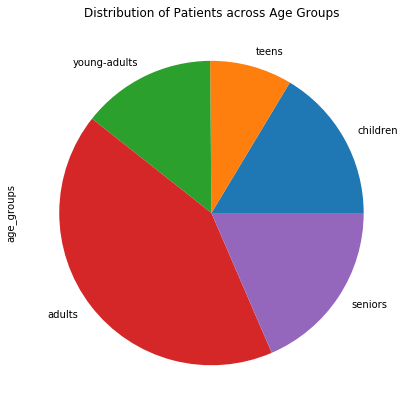

In [34]:
# and here is a better visual
df.groupby(['age_groups'])['age_groups'].count().plot(kind='pie',figsize=[7,7])
plt.title('Distribution of Patients across Age Groups');

As we can see, most of the data is collected for adults (age between 30 and 60). Although our selection of age groups was arbitrary, it helped clarify how the data was collected across ages. 

Similarly we will show the distribution across gender:

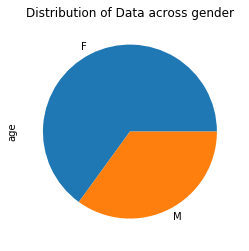

In [36]:
# relations across genders

df.groupby('gender').count()['age'].plot(kind='pie');
plt.title("Distribution of Data across gender");

This shows that the data collected for females is much higher than that for males.

In [37]:
df.groupby(['gender','show'])['show'].count()

gender  show
F       No      14280
        Yes     56578
M       No       7535
        Yes     30599
Name: show, dtype: int64

Similarly, the data show that people who show up for appointments are greater for both genders.

<a id='conclusions'></a>
## Conclusions

Although our capabilities in using pandas and matplotlib are still limited, they allowed us to make several conclusions about the dataset and answer - to a certain extent - the posed questions:

 #### What factors are important for knowing if a patient will show up to an appointment or not?
> Factors such as chronic illnesses such as diabetes, are important in knowing that the patient is more likely to show up for the appointment.
> Being enrolled in a welfare program or receiving an sms reminder seem to have a negative effect although more analysis is needed to confirm the cause of it.

 #### How is the problem (not showing for appointments) distributed accross the locations in Brazil?
> In general, in all the locations in Brazil, patients have a high rate of showing up for appointments (> 70%) except for the city of "Ilhas Oceanicas de trindade". However, this could be due to some error.

#### How is the problem distributed across age and gender of patients? 

> Thee majority of the patients in the dataset seem to be adult females (age between 30 and 60). However, showing up for appointments seems to be consistent among patients regardless of age and gender (more patients show up for appointments than those who don't).